In this notebook, your task is to try to improve the sleep stage classification model for the [Haaglanden Medisch Centrum Sleep Staging Database](https://physionet.org/content/hmc-sleep-staging/1.1/) you created in your last homework assignment. You should implement enhancements from at least two of the three categories below:
* **Modify your features (Steps 2 & 4):** Manually create new features, add feature selection
* **Improve your dataset distribution (Step 5):** Oversample underrepresented sleep stages during training, undersample overrepresented sleep stages during training
* **Improve your model architecture (Steps 6 & 7):** Try different model architectures, try different hyperparameters, add an automatic hyperparameter search


While we are not expecting you to achieve a specific accuracy rate, this is your chance to try out different techniques to potentially enhance your machine learning pipeline. Bear in mind that while overall model accuracy may not always improve, changes you make may modify your model's ability to discern certain classes.

You may either modify and resubmit your HW7 notebook or you may copy cells over from your previous notebook into this one. If you go with the former, be sure to rename the notebook so that it is clear that you are resubmitting a new file.

Regardless of how you submit your homework, you must write a brief report on the modifications that you made from your initial machine learning pipeline and the impact those modifications had on your model's performance.

# Important: Run this code cell each time you start a new session!

In [ ]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install os
!pip install opencv-python
!pip install scikit-learn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import sklearn

ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


# Step 1: Define the Problem You Are Trying to Solve

As a reminder, the goal of this dataset is to enable researchers to automatically identify sleep stages using polysomnographic (PSG) recordings. Given the large size of these recordings, we will work only work with data from 3 participants from this 151-person study. Patient recordings were randomly selected from a heterogeneous group of patients who were referred for PSG examination due to different sleep disorders.

Participants were instrumented with the minimal recommended set of sensors necessary to visually score sleep stages: four EEG (F4/M1, C4/M1, O2/M1, and C3/M2), two EOG (E1/M2 and E2/M2), one bipolar chin EMG, and one ECG (single modified lead II) data stream. Participants slept in the sleep clinic for one night. Their PSG recordings were reviewed and annotated by expert clinicians according to discrete 30-second windows. An example of this annotation process is shown below (note: this is merely an illustration and does not represent the true time-scale of the data):

<img src="https://drive.google.com/uc?id=1UnkMe1WmP813ZGyS7ynT_CMqP2Nr2do0" width=750px/>

All data was recorded at 256 Hz. For your convenience, the data has already been processed so that there is one `.csv` per participant in a folder called `data` with the following naming convention: `SN{subject_id}.csv`. These files have the following columns:

| Column # | Description |
|----------|-------------|
| 1 | Time in seconds|
| 2 | Annotation given by the sleep experts (W, N1, N2, N3, R) |
| 3–6 | EEG data |
| 7 | EMG data |
| 8–9 | EOG data |
| 10 | ECG data |

In this notebook, your goal will be to create a ***classification model*** that infers sleep stages from 30-second windows of PSG data.

# Step 2: Create Your Features and Labels

Remember the `.csv` file that you created in the previous homework? That file already contains all of the data you will need to train your model.

**(Part 1)** If you do not have the `.csv` file from the previous homework on your local machine, you can regenerate it by going back to the previous homework, re-running the entire notebook, and then downloading the `.csv` that gets created in that notebook's workspace (folder icon on the left side).

Once you have the file, return here and upload it to this notebook's workspace. Then, write a line of code that will load the data from this `.csv` file as a `DataFrame`.

In [ ]:
df = pd.read_csv('psg_data.csv')

**(Part 2)** Write code that will store the labels as a `numpy` array called `y`.

In [ ]:
y = df['Annotation'].values

**(Part 3)** Write code that will store the features as a `numpy` array called `x`.

*Hint:* Remember that there are more columns in this `DataFrame` than features and labels.

In [ ]:
x = df.drop(['Subject ID', 'Start Time', 'Annotation'], axis=1).values

# Step 3: Decide How the Data Should Be Split for Training and Testing

Recall that although our dataset only has one recording for each patient, we split those recordings into multiple windows. If we were to do a single 80%-20% split, we would likely have a single patient's data divided across the train and test sets, which is particularly problematic for this dataset because consecutive windows from the same patient are likely to be highly similar. Instead, you will need to use subject-wise cross-validation to generate one split for each patient in the dataset.

**(Part 4)** Write code that will store the group ID associated with each sample as a `numpy` array called `groups`.

In [ ]:
groups = df['Subject ID'].values

You will actually perform the cross-validation in Step 8.

# Step 4: (Optional) Add Feature Selection

Since I created quite a few features, I am going to add a feature selection step to pick high-scoring features.

In [ ]:
from sklearn.feature_selection import SelectPercentile, f_classif
feat_select = SelectPercentile(f_classif, percentile=80)

# Step 5: (Optional) Balance Your Dataset

When I looked at the distribution of labels, I noticed that its fairly uneven. There are nearly over 3 times the number of `N2` samples compared to the number of `N1` samples.

In [ ]:
df['Annotation'].value_counts()

N2    907
W     636
R     467
N3    397
N1    257
Name: Annotation, dtype: int64

In [ ]:
!pip install imblearn
from imblearn.over_sampling import SMOTE

# Step 6: Select an Appropriate Model

You should use a `RandomForestClassifier` as your model architecture for this assignment. You will actually initialize this model in Step 8.

# Step 7: (Optional) Select Your Hyperparameters

We will add `GridSearchCV` to tune a subset of hyperparameters for our model. These hyperparameters and their possible values for our search are as follows:

In [ ]:
param_grid = {'n_estimators': [25, 50, 100, 200],
                'criterion' : ['gini', 'entropy', 'log_loss'],
                'max_depth': [2, 5, 10, None]}

# Step 8: Train and Test Your Model

In [ ]:
from sklearn.model_selection import LeaveOneGroupOut, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectPercentile, f_classif
from imblearn.over_sampling import SMOTE

# Set the random seed to an arbitrary number of your choosing
np.random.seed(42)

# Get the features, labels, and grouping variables
x = df.drop(['Subject ID', 'Start Time', 'Annotation'], axis=1).values
y = df['Annotation'].values
groups = df['Subject ID'].values

# Initialize a data structure to save our final results,
# assuming all of the predictions are empty to start
y_pred = np.empty(y.shape, dtype=object)

# Split the data into folds
loocv = LeaveOneGroupOut()
for train_idxs, test_idxs in loocv.split(x, y, groups):
    # Split the data into train and test
    x_train = x[train_idxs]
    y_train = y[train_idxs]
    x_test = x[test_idxs]
    y_test = y[test_idxs]

    # Balance the training dataset
    oversample = SMOTE()
    x_train, y_train = oversample.fit_resample(x_train, y_train)

    # Select the most useful features
    feat_select = SelectPercentile(f_classif, percentile=50)
    feat_select.fit(x_train, y_train)
    x_train = feat_select.transform(x_train)
    x_test = feat_select.transform(x_test)

    # Perform a hyperparameter search
    param_grid = {'n_estimators': [25, 50, 100, 200],
                  'criterion' : ['gini', 'entropy', 'log_loss'],
                  'max_depth': [2, 5, 10, None]}
    clf = RandomForestClassifier(random_state=42)
    grid_search_clf = GridSearchCV(clf, param_grid, cv=5)
    grid_search_clf.fit(x_train, y_train)

    # Predict on the transformed test data
    y_test_pred = grid_search_clf.predict(x_test)
    y_pred[test_idxs] = y_test_pred

[485 485 485 485 485]
[598 598 598 598 598]
[739 739 739 739 739]


# Step 9: Use an Appropriate Method for Interpreting Results

**(Part 6)** Create a confusion matrix showing the accuracy of your model.

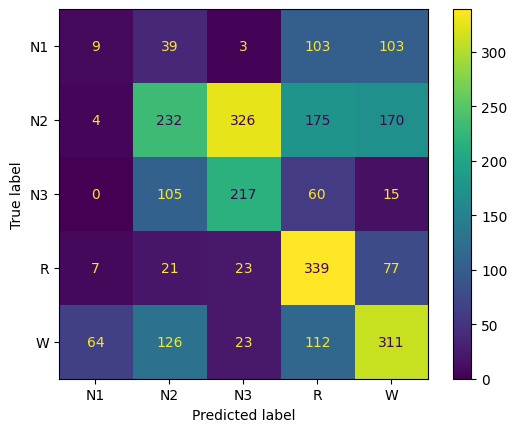

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
classes = np.unique(y_pred)
ConfusionMatrixDisplay.from_predictions(y, y_pred,
                                        display_labels=classes)
plt.show()

**(Part 7)** Calculate the overall accuracy of your model.

In [ ]:
from sklearn.metrics import accuracy_score
print(f'Accuracy: {accuracy_score(y, y_pred)}')

Accuracy: 0.4159159159159159


# Write-Up

*Note:* The answers to both questions can be written as a paragraph, a bulleted list, or a table. However, you must answer all parts of the questions, so complete sentences are strongly recommended.

**(Part 1)** What modifications did you make to your machine learning pipeline. What were you hoping these modifications would achieve?

Write your answer here: I implemented the following modifications to my code...
* Feature selection to account for the fact that I created lots of features across all of the sensors
* Hyperparameter tuning to try to optimize the hyperparameters for my `RandomForestClassifier`
* `SMOTE` oversampling to account for the fact that there many more cases of some sleep stages (`N2`, `W`) than others

I decided not to create new features since I felt my list was fairly comprehensive, and I also decided not to try different model architectures because I didn't think it would make a big difference (maybe it would though...)

**(Part 2)** How did you model's performance change after you made these modifications? Did they improve overall accuracy? Did they improve the model's ability to identify certain classes?

Write your answer here: Well, my model's overall accuracy decreased slightly when I applied all of these changes. As a consolation, it seems like this model is much better at distinguishing `R` from other classes, but that's partly because this model is more likely to predict `R` across all samples compared to my old model.

This could be an indicator that I was already maxing out on the potential accuracy that can be acheived on this dataset, but considering removing features did not improve performance, maybe I would actually need to look at adding more features that are more strongly correlated with sleep stage.